# DSE Course 1, Session 5: Regression and Analysis

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will look at fitting data to a curve using **regression**. We will also look at using regression to make **predictions** for new data points by dividing our data into a training and a testing set. Finally we will examine how much error we make in our fit and then in our predictions by computing the mean squared error, at the variance and bias.

<br>

---


### Load libraries which will be needed in this Notebook



In [ ]:
# Pandas library for the pandas dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import numpy 
import numpy as np

# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
from ipywidgets import interact

# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 20})

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2


## 5.1 What is regression? 

It is the process of finding a relationship between **_dependent_** and **_independent_** variables to find trends in data. This abstract definition means that you have one variable (the dependent variable) which depends on one or more variables (the independent variables). One of the reasons for which we want to regress data is to understand whether there is a trend between two variables. 

For instance, let's say we had data points showing how tired we are respective to the amount of coffee we drink. In the case of linear regression, the question would be - is the data quantity of how tired I am linearly proportional to the amount of coffee I drink, i.e. can we use a line to represent the relationship between these two variables?




## 5.2  Linear regression fitting with scikit-learn

### 5.2.1 Loading the dataset

Here we'll load in our wine dataset

```
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/ds_for_engineers/main/data/wine_quality/winequalityN.csv")
```



In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/ds_for_engineers/main/data/wine_quality/winequalityN.csv")
df.shape

(6497, 13)

#### Exercise 1: rudimentary EDA
What does the data look like? Remember how to visualize data in a pandas dataframe (Sessions 3 and 4) 

<ol>
<li> for every column calculate the

  * skew: `df.skew()`
  * kurtosis: `df.kurtosis()`
  * pearsons correlation with the dependent variable: `df.corr()`
  * number of missing entries `df.isnull()`

and organize this into a new dataframe

_note:_ pearsons is just one type of correlation, another available to us **_spearman_** which differs from pearsons in that it depends on ranked values rather than their direct quantities, you can read more [here](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)

In [ ]:
# Cell for exercise 1

skew = df.skew()
kurt = df.kurtosis()
pear = df.corr()['quality']
null = df.isnull().sum()

dff = pd.DataFrame([skew, kurt, pear, null])
dff = dff.T
dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'null count']
dff

,skew,kurtosis,pearsons _quality,null count
fixed acidity,1.722805,5.057727,-0.077031,10.0
volatile acidity,1.495512,2.827081,-0.265953,8.0
citric acid,0.473032,2.401582,0.085706,3.0
residual sugar,1.435000,4.358134,-0.036825,2.0
chlorides,5.399849,50.894874,-0.200886,2.0
free sulfur dioxide,1.220066,7.906238,0.055463,0.0
total sulfur dioxide,-0.001177,-0.371664,-0.041385,0.0
density,0.503602,6.606067,-0.305858,0.0
pH,0.386966,0.370068,0.019366,9.0
sulphates,1.798467,8.659892,0.038729,4.0


I have gone ahead and repeated this exercise with the red vs white wine types:

In [ ]:
red = df.loc[df['type'] == 'red']
wht = df.loc[df['type'] == 'white']

skew = red.skew()
kurt = red.kurtosis()
pear = red.corr()['quality']
null = red.isnull().sum()
med = red.median()
men = red.mean()

dff = pd.DataFrame([skew, kurt, pear, null, med, men])
dff = dff.T
dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'null count', 'median',
               'mean']
dff

skew = wht.skew()
kurt = wht.kurtosis()
pear = wht.corr()['quality']
null = wht.isnull().sum()
med = wht.median()
men = wht.median()

dffw = pd.DataFrame([skew, kurt, pear, null, med, men])
dffw = dffw.T
dffw.columns = ['skew', 'kurtosis', 'pearsons _quality', 'null count', 'median',
                'mean']

desc = pd.concat([dff, dffw], keys=['red', 'white'])

In [ ]:
desc.head()

skew   kurtosis  ...  median      mean
red fixed acidity     0.982192   1.132624  ...   7.900  8.322104
    volatile acidity  0.672862   1.226846  ...   0.520  0.527738
    citric acid       0.317891  -0.788476  ...   0.260  0.271145
    residual sugar    4.540655  28.617595  ...   2.200  2.538806
    chlorides         5.680347  41.715787  ...   0.079  0.087467

[5 rows x 6 columns]

In [ ]:
def my_fig(metric=desc.columns):
  fig, ax = plt.subplots(1, 1, figsize=(10,10))
  pd.DataFrame(desc[metric]).unstack()[metric].T.plot(kind='barh', ax=ax)

#### Question 1: Discussion Around EDA Plot

What do we think of this plot?

> `metric = mean`, the cholrides values <br>
`metric = kurtosis`, residual sugar <br>
`metric = pearsons _quality`, _magnitudes_ and _directions_ <br>
How to improve the plot, what other plots would we like to see?

In [ ]:
interact(my_fig)

interactive(children=(Dropdown(description='metric', options=('skew', 'kurtosis', 'pearsons _quality', 'null c…

<function __main__.my_fig>

(0.0, 0.61)

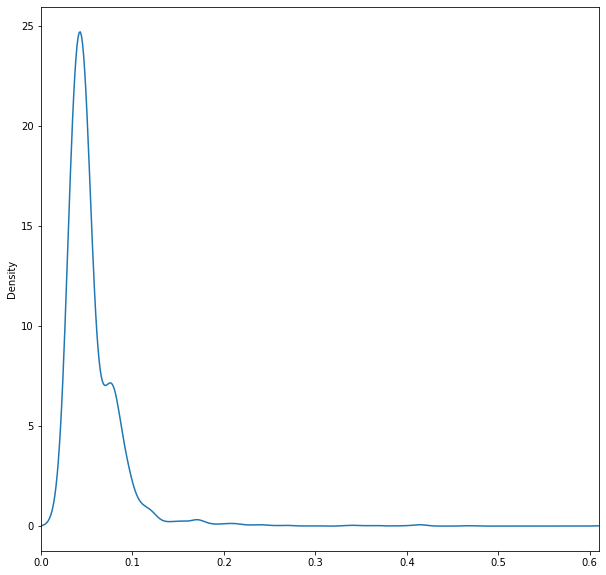

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df['chlorides'].plot(kind='kde',ax=ax)
ax.set_xlim(0,.61)

In [ ]:
df['chlorides'].sort_values(ascending=False)[:20]

5156    0.611
5049    0.610
5004    0.467
4979    0.464
5590    0.422
5652    0.415
6268    0.415
6270    0.415
6217    0.414
5949    0.414
5349    0.413
6158    0.403
4981    0.401
5628    0.387
6063    0.369
4915    0.368
5067    0.360
5179    0.358
484     0.346
5189    0.343
Name: chlorides, dtype: float64

### 5.2.2 Visualizing the data set - motivating regression analysis

We can create a scatter plot of fixed acidity vs density of red wine in the dataset using `df.plot()` and see that there appears to be a general trend between the two features:

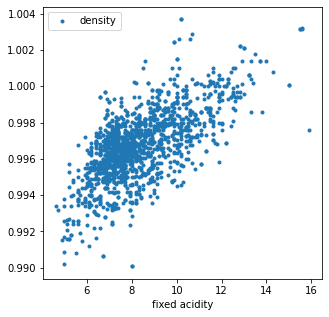

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df.loc[df['type'] == 'red'].plot(x='fixed acidity', y='density', ax=ax, 
                                 ls='', marker='.')

### 5.2.3 Estimating the regression coefficients

It looks like density increases with fixed acidity following a line, maybe something like

$$y(t)= m\cdot t + b  \;\;\;\;\;\;\;\;\sf{eq. 1}$$ 

with $y=\sf density$, $t=\sf fixed acidity$, $m$ the slope and $b$ the intercept. 

To solve the problem, we need to find the values of $b$ and $m$ in equation 1 to best fit the data. This is called **linear regression**.

In linear regression our goal is to minimize the error between computed values of positions $y^{\sf calc}(t_i)\equiv y^{\sf calc}_i$ and known values $y^{\sf exact}(t_i)\equiv y^{\sf exact}_i$, i.e. find $b$ and $m$ which lead to lowest value of

$$\epsilon (m,b) =SS_{\sf res}=\sum_{i=1}^{N}\left(y^{\sf exact}_i - y^{\sf calc}_i\right)^2 = \sum_{i=1}^{N}\left(y^{\sf exact}_i - m\cdot t_i - b \right)^2\;\;\;\;\;\;\;\;\;\;\;\sf{eq. 2}$$

To find out more see e.g. https://en.wikipedia.org/wiki/Simple_linear_regression


#### Question 2: linear regression loss function
> Do we always want *m* and *b* to be large positive numbers so as to minimize eq. 2? 


Luckily [scikit-learn](https://scikit-learn.org/stable/) contains many functions related to regression including [linear regression](https://scikit-learn.org/stable/modules/linear_model.html). 

The function we will use is called <code> LinearRegression() </code>. 

```
# Create linear regression object
regr = linear_model.LinearRegression()

# Use model to fit to the data, the x values are densities and the y values are fixed acidity
# Note that we need to reshape the vectors to be of the shape x - (n_samples, n_features) and y (n_samples, n_targets)
x = red['density'].values.reshape(-1, 1)
y = red['fixed acidity'].values.reshape(-1, 1)
```

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Use model to fit to the data, the x values are densities and the y values are fixed acidity
# Note that we need to reshape the vectors to be of the shape x - (n_samples, n_features) and y (n_samples, n_targets)
x = red['density'].values.reshape(-1, 1)
y = red['fixed acidity'].values.reshape(-1, 1)


```
print(red['density'].values.shape, red['fixed acidity'].values.shape)
print(x.shape, y.shape)
```

In [ ]:
print(red['density'].values.shape, red['fixed acidity'].values.shape)
print(x.shape, y.shape)

(1599,) (1599,)
(1599, 1) (1599, 1)


```
# Fit to the data
regr.fit(x, y)

# Extract the values of interest
m = regr.coef_[0][0]
b = regr.intercept_[0]

# Print the slope m and intercept b
print('Scikit learn - Slope: ', m , 'Intercept: ', b )
```

What happens when we try to fit the data as is?

In [ ]:
# Fit to the data
# regr.fit(x, y)

Let's look back at our dataset description dataframe above, what do we notice, what contains null values?

There are several strategies for dealing with null values. For now let's take the simplest case, and drop rows in our dataframe that contain null

In [ ]:
x = red[['density', 'fixed acidity']].dropna(axis=0)['density'].values.reshape(-1, 1)
y = red[['density', 'fixed acidity']].dropna(axis=0)['fixed acidity'].values.reshape(-1, 1)

In [ ]:
# Fit to the data
regr.fit(x, y)

# Extract the values of interest
m = regr.coef_[0][0]
b = regr.intercept_[0]

# Print the slope m and intercept b
print('Scikit learn - Slope: ', m , 'Intercept: ', b )

Scikit learn - Slope:  616.0131428066102 Intercept:  -605.6880086750525


#### Exercise 2: calculating Y_pred
Estimate the values of $y$ by using your fitted parameters. Hint: Use your <code>regr.coef_</code> and <code>regr.intercept_</code> parameters to estimate y_pred following equation 1


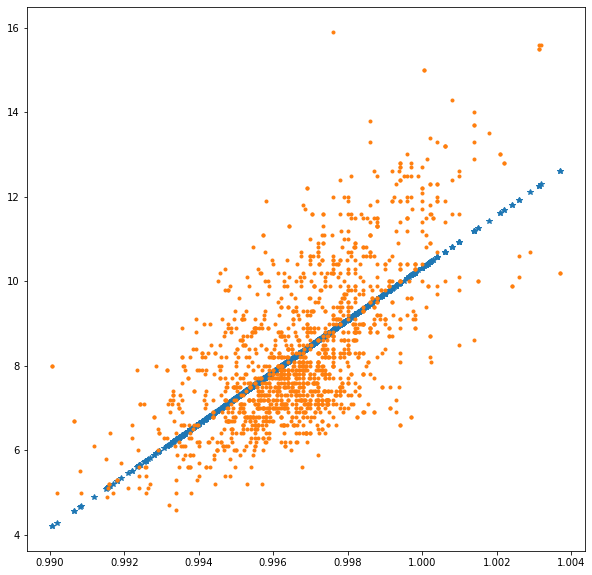

In [ ]:
y_pred = m * x + b
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(x, y_pred, ls='', marker='*')
ax.plot(x, y, ls='', marker='.')

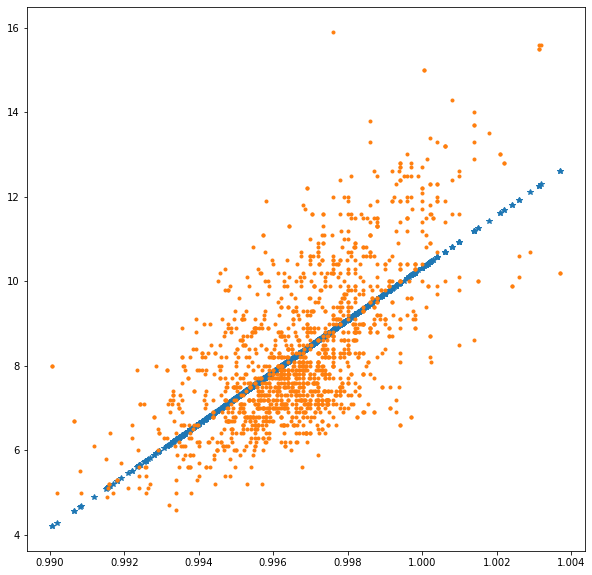

In [ ]:
# Another way to get this is using the regr.predict function
y_pred = regr.predict(x)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(x, y_pred, ls='', marker='*')
ax.plot(x, y, ls='', marker='.')

## 5.3 Error and topics of model fitting (assessing model accuracy)

### 5.3.1 Measuring the quality of fit

#### 5.3.1.1 Mean Squared Error

The plot in Section 5.2.3 looks good, but numerically what is our error? What is the mean value of $\epsilon$, i.e. the **Mean Squared Error (MSE)**?

$${\sf MSE}=\epsilon_{\sf ave} = \frac{\sum_{i=1}^{N_{\sf times}}\left(y^{\sf exact}_i - m\cdot t_i - b \right)^2}{N_{\sf times}}\;\;\;\;\;\sf eq. 3$$

```
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))
```

In [ ]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))

Mean squared error: 1.68


#### 5.3.1.2 R-square

Another way to measure error is the regression score, $R^2$. $R^2$ is generally defined as the ratio of the total sum of squares $SS_{\sf tot} $ to the residual sum of squares $SS_{\sf res} $:

$$SS_{\sf tot}=\sum_{i=1}^{N} \left(y^{\sf exact}_i-\bar{y}\right)^2\;\;\;\;\; \sf eq. 4$$
$$SS_{\sf res}=\sum_{i=1}^{N} \left(y^{\sf exact}_i - y^{\sf calc}_i\right)^2\;\;\;\;\; \sf eq. 5$$
$$R^2 = 1 - {SS_{\sf res}\over SS_{\sf tot}} \;\;\;\;\;\; \sf eq. 6$$

In eq. 4, $\bar{y}=\sum_i y^{\sf exact}_i/N$ is the average value of y for $N$ points. The best value of $R^2$ is 1 but it can also take a negative value if the error is large.

See all the different regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

#### Question 3
> Do we need a large value of $SS_{\sf tot}$ to minimize $R^2$ - is this something which we have the power to control?

```
# Print the coefficient of determination - 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))
```

In [ ]:
# Print the coefficient of determination - 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

Coefficient of determination: 0.45


### 5.3.2 Corollaries with classification models

For classification tasks, we typically assess accuracy vs MSE or R-square, since we are dealing with categorical rather than numerical predictions.

In [ ]:
y_train = df['type'].values.reshape(-1,1)
x_train = df['quality'].values.reshape(-1,1)

In [ ]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# make class predictions for the testing set
y_pred_class = logreg.predict(x_train)

In [ ]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train, y_pred_class))

0.7538864091118977


### 5.3.3 Beyond a single input feature

(_also: quick appreciative beat for folding in domain area expertise into our models and features_)

The **acidity** of the wine (the dependent variable v) could depend on:

* potassium from the soil (increases alkalinity)
* unripe grapes (increases acidity)
* grapes grown in colder climates or reduced sunshine create less sugar (increases acidity)
* preprocessing such as adding tartaric acid to the grape juice before fermentation (increases acidity)
* malolactic fermentation (reduces acidity)
* \+ others

So in our lab today we will look at folding in additional variables in our dataset into the model
<hr style="border:1px solid grey"> </hr>


## 5.4 Multivariate regression

Let's now turn our attention to wine quality.

The value we aim to predict or evaluate is the quality of each wine in our dataset. This is our dependent variable. We will look at how this is related to the 12 other independent variables, also known as *input features*.

In [ ]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
red = df.loc[df['type'] == 'red']

### 5.4.1 Linear regression with all input fields

For this example, notice we have a categorical data variable in the 'type' column. We will ignore this for now, and only work with our red wines. In the future we will discuss how to deal with categorical variable such as this in a mathematical representation.

In [ ]:
features = list(red.columns[1:])
features.remove('density')
X = red.dropna(axis=0)[features].values
y = red.dropna(axis=0)['density'].values

In [ ]:
red.isnull().sum(0) # we are getting rid of some nast nulls!

type                    0
fixed acidity           2
volatile acidity        1
citric acid             1
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      2
sulphates               2
alcohol                 0
quality                 0
dtype: int64



```
# Create linear regression object - note that we are using all the input features
regr = linear_model.LinearRegression()
regr.fit(X, y)
Y_calc = regr.predict(X)
```



In [ ]:
# Create linear regression object - note that we are using all the input features
regr = linear_model.LinearRegression()
regr.fit(X, y)
Y_calc = regr.predict(X)

Let's see what the coefficients look like ... 

```
print("Fit coefficients: \n", regr.coef_, "\nNumber of coefficients:", len(regr.coef_))
```

In [ ]:
print("Fit coefficients: \n", regr.coef_, "\nNumber of coefficients:", len(regr.coef_))

Fit coefficients: 
 [ 1.33398390e-02 -6.18649559e-01 -1.14785495e-03  8.23891948e-01
 -2.45901571e-03  1.08365866e-03  1.88479254e+01  1.39742748e-02
 -1.61597070e-01  2.67094861e-02 -4.36051797e-02] 
Number of coefficients: 11


We have 11 !!! That's because we are regressing respect to all **11 independent variables**!!!

So now, $$y_{\sf calc}= m_1x_1 +\, m_2x_2 \,+ \,m_3x_3 \,+\,... \,+ \,b =\sum_{i=1}^{13}m_i x_i + b\;\;\;\;\; \sf eq. 7$$

```
print("We have 13 slopes / weights:\n\n", regr.coef_)
print("\nAnd one intercept: ", regr.intercept_)
```

In [ ]:
print("We have 11 slopes / weights:\n\n", regr.coef_)
print("\nAnd one intercept: ", regr.intercept_)

We have 11 slopes / weights:

 [ 1.33398390e-02 -6.18649559e-01 -1.14785495e-03  8.23891948e-01
 -2.45901571e-03  1.08365866e-03  1.88479254e+01  1.39742748e-02
 -1.61597070e-01  2.67094861e-02 -4.36051797e-02]

And one intercept:  -18.254697381318046


```
# This size should match the number of columns in X
if len(X[0]) == len(regr.coef_):
    print("All good! The number of coefficients matches the number of input features.")
else:
    print("Hmm .. something strange is going on.")
```

In [ ]:
# This size should match the number of columns in X
if len(X[0]) == len(regr.coef_):
    print("All good! The number of coefficients matches the number of input features.")
else:
    print("Hmm .. something strange is going on.")

All good! The number of coefficients matches the number of input features.


Let's **evaluate the error** by computing the MSE and $R^2$ metrics (see eq. 3 and 6).

```
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, y_calc))
print('Coefficient of determination: %.2f' % r2_score(y, y_calc))
```

In [ ]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, regr.predict(X)))
print('Coefficient of determination: %.2f' % r2_score(y, regr.predict(X)))

Mean squared error: 0.00
Coefficient of determination: 0.84


We can also look at how well the computed values match the true values graphically by generating a scatterplot.

```
# Scatterplot
sns.scatterplot(x=Y_calc,y=Y, color="cornflowerblue", s=50)
plt.title("Linear regression - computed values on entire data set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()
```

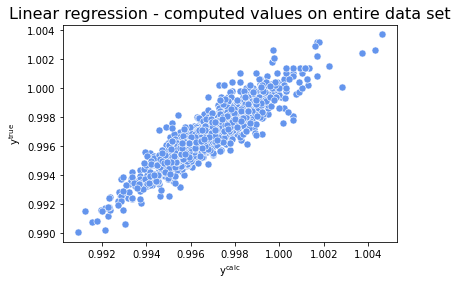

In [ ]:
# Scatterplot
sns.scatterplot(x=regr.predict(X),y=y, color="cornflowerblue", s=50)
plt.title("Linear regression - computed values on entire data set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

### 5.4.2 Splitting into train and test sets

To see whether we can predict, we will carry out our regression only on a part, 80%, of the full data set. This part is called the **training** data. We will then test the trained model to predict the rest of the data, 20% - the **test** data. The function which fits won't see the test data until it has to predict it. 

**We will motivate the use of train/test sets more explicitly in Course 2 Session 1**

We start by splitting out data using scikit-learn's <code> train_test_split() </code> function:

```
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state=42)
                                                    ```

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state=42)

Now we check the size of <code> y_train </code> and <code> y_test </code>, the sum should be the size of y! If this works then we move on and carry out regression but we only use the training data!

```
if len(y_test)+len(y_train) == len(y):
    
    print('All good, ready to to go and regress!\n')
    
    # Carry out linear regression
    print('Running linear regression algorithm on the training set\n')
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

    # Predict on the test set
    y_pred_test = regr.predict(X_test)
```

In [ ]:
if len(y_test)+len(y_train) == len(y):
    
    print('All good, ready to to go and regress!\n')
    
    # Carry out linear regression
    print('Running linear regression algorithm on the training set\n')
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

    # Predict on the test set
    y_pred_test = regr.predict(X_test)

All good, ready to to go and regress!

Running linear regression algorithm on the training set

Fit coefficients and intercept:

 [ 9.33178495e-04  6.16926970e-04  3.97991174e-06  4.16370328e-04
  1.62394928e-03 -9.91971827e-06  2.69686071e-06  5.05056377e-03
  1.31752524e-03 -9.38947432e-04  7.24835766e-06] 

 0.9796448738246895


Now we can plot our predicted values to see how accurate we are in predicting. We will generate a scatterplot and computing the MSE and $R^2$ metrics of error.

```
sns.scatterplot(x=y_pred_test, y=y_test, color="mediumvioletred", s=50)

plt.title("Linear regression - predict test set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_test))
```

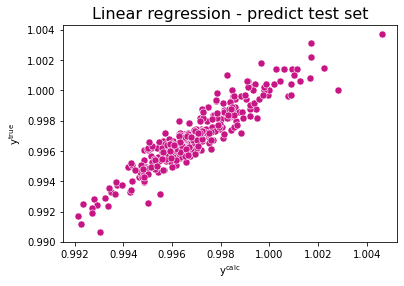

Mean squared error: 0.00
Coefficient of determination: 0.87


In [ ]:
sns.scatterplot(x=y_pred_test, y=y_test, color="mediumvioletred", s=50)

plt.title("Linear regression - predict test set", fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_test))

### 5.4.6 Other data considerations

* Do we need all the independent variables? 
  * Topics of interential statistics covered in sessions 6 and 7
  * We will look at prediction ability as a function of input features in the lab today

* Can we output integer quality scores? 
  * Topics of non-binary classification tasks covered in Course 2

#### Question 4: Discuss improvements

> How else can we improve the model?

### 5.4.7 Other regression algorithms

There are many other regression algorithms the two we want to highlight here are Ridge, LASSO, and Elastic Net. They differ by an added term to the loss function. Let's review. Eq. 2 expanded to multivariate form yields:

$$\sum_{i=1}^{N}(y_i - \sum_{j=1}^{P}x_{ij}\beta_{j})^2$$

for Ridge regression, we add a **_regularization_** term known as **_L2_** regularization:

$$\sum_{i=1}^{N}(y_i - \sum_{j=1}^{P}x_{ij}\beta_{j})^2 + \lambda \sum_{j=1}^{P}\beta_{j}^2$$

for **_LASSO_** (Least Absolute Shrinkage and Selection Operator) we add **_L1_** regularization:

$$\sum_{i=1}^{N}(y_i - \sum_{j=1}^{P}x_{ij}\beta_{j})^2 + \lambda \sum_{j=1}^{P}|\beta_{j}|$$

The key difference here is that LASSO will allow coefficients to shrink to 0 while Ridge regression will not. **_Elastic Net_** is a combination of these two regularization methods.


```
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

# Predict on the test set
Y_calc_test = regr.predict(X_test)
```

In [ ]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
print('Fit coefficients and intercept:\n\n', regr.coef_, '\n\n', regr.intercept_ )

# Predict on the test set
Y_calc_test = regr.predict(X_test)

Fit coefficients and intercept:

 [ 9.09641067e-04  6.43264795e-04  2.78882604e-05  4.16939725e-04
  1.03446440e-03 -9.27657730e-06  2.32153681e-06  4.66188798e-03
  1.32184520e-03 -9.33484848e-04 -2.26313220e-07] 

 0.9811476280427127


```
sns.scatterplot(x=Y_calc_test, y=y_test, color="lightseagreen", s=50)
plt.title("Ridge regression - predict test set",fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))
```

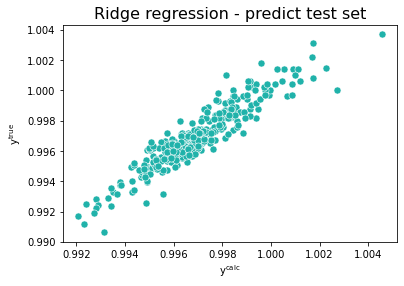

Mean squared error: 0.00
Coefficient of determination: 0.87


In [ ]:
sns.scatterplot(x=Y_calc_test, y=y_test, color="lightseagreen", s=50)
plt.title("Ridge regression - predict test set",fontsize=16)
plt.xlabel("y$^{\sf calc}$")
plt.ylabel("y$^{\sf true}$")
plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y_test, Y_calc_test))
print('Coefficient of determination: %.2f' % r2_score(y_test, Y_calc_test))

#### Exercise 3: Tune Hyperparameter for Ridge Regression

Use the docstring to peak into the hyperparameters for Ridge Regression. What is the optimal value of lambda?

Plot the $\beta$ values vs $\lambda$ from the results of your analysis

In [ ]:
# cell for exercise 3
out_lambdas = []
out_coefs = []
out_scores = []
for i in range(10):
  lambdas = []
  coefs = []
  scores = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20)
  for lamb in range(1,110):
    regr = linear_model.Ridge(alpha=lamb/50, normalize=True)
    regr.fit(X_train, y_train)
    lambdas.append(lamb)
    coefs.append(regr.coef_)
    scores.append(r2_score(y_test, regr.predict(X_test)))
    # print('MSE: %.4f' % mean_squared_error(y_test, regr.predict(X_test)))
    # print('R2: %.4f' % r2_score(y_test, regr.predict(X_test)))
  out_lambdas.append(lambdas)
  out_coefs.append(coefs)
  out_scores.append(scores)

In [ ]:
coef_means = np.array(out_coefs).mean(axis=0)
coef_stds = np.array(out_coefs).std(axis=0)
results_means = pd.DataFrame(coef_means,columns=features)
results_stds = pd.DataFrame(coef_stds,columns=features)
results_means['lambda'] = [i/50 for i in lambdas]

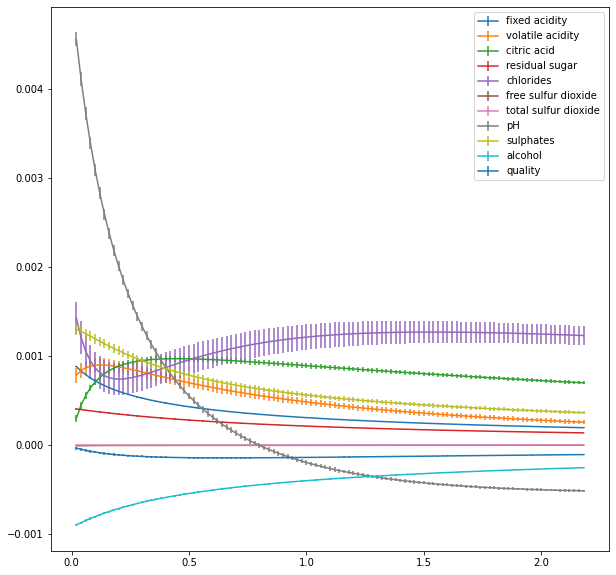

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for feat in features:
  ax.errorbar([i/50 for i in lambdas], results_means[feat], yerr=results_stds[feat], label=feat)
# results.plot('lambda', 'scores', ax=ax[1])
ax.legend()

In [ ]:
results = pd.DataFrame(coefs,columns=features)
results['lambda'] = [i/50 for i in lambdas]
results['scores'] = scores

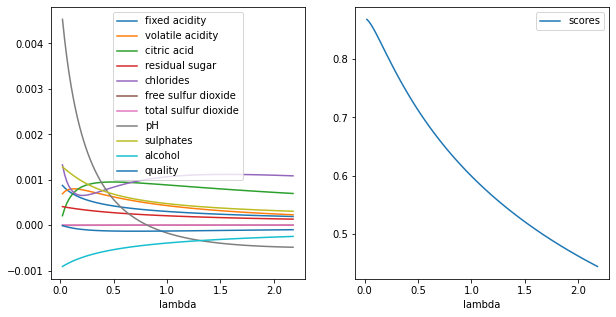

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for feat in features:
  results.plot('lambda', feat, ax=ax[0])
results.plot('lambda', 'scores', ax=ax[1])

## 5.5 Lab for Regression


### Problem 1) Number and choice of input features

* Load the red wine dataset and evaluate how the linear regression predictions changes as you change the **number and choice of input features**. The total number of columns in X  is 11 and each column represent a specific input feature. 

* Estimate the MSE
```
print(X_train.shape)
```

In [ ]:
print(X_train.shape)

(1274, 11)


If you want to use the first 5 features you could proceed as following:

```
X_train_five = X_train[:,0:5]
X_test_five = X_test[:,0:5]
```

In [ ]:
X_train_five = X_train[:,0:5]
X_test_five = X_test[:,0:5]

Check that the new variables have the shape your expect

```
print(X_train_five.shape)
print(X_test_five.shape)
```

In [ ]:
print(X_train_five.shape)
print(X_test_five.shape)

(1274, 5)
(319, 5)


Now you can use these to train your linear regression model and repeat for different numbers or sets of input features! Note that you do not need to change the output feature! It's size is independent from the number of input features, yet recall that its length is the same as the number of values per input feature.

Questions to think about while you work on this problem
- How many input feature variables does one need? Is there a maximum or minimum number? 
- Could one input feature variable be better than the rest?
- What if values are missing for one of the input feature variables - is it still worth using it?
- Can you use **_L1_** or **_L2_** to determine these optimum features more quickly?

### Problem 2) Type of regression algorithm


Try using other types of linear regression methods on the wine dataset: the LASSO model and the Elastic net model which are described by the 

<code > sklearn.linear_model.ElasticNet() </code> <br>
<code > sklearn.linear_model.Lasso() </code>

scikit-learn functions.

For more detail see [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) and [Lasso](  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso).

Questions to think about while you work on this problem
- How does the error change with each model?
- Which model seems to perform best?
- How can you optimize the hyperparameter, $\lambda$
- Does one model do better than the other at determining which input features are more important?
- How about non linear regression / what if the data does not follow a line?
- How do the bias and variance change for each model

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [ ]:
for model in [ElasticNet, Lasso, Ridge, LinearRegression]:
  regr = model()
  regr.fit(X_train, y_train)
  print('Mean squared error: %.2f' % mean_squared_error(y_test, regr.predict(X_test)))
  print('Coefficient of determination: %.2f' % r2_score(y_test, regr.predict(X_test)))

Mean squared error: 0.03
Coefficient of determination: -0.00
Mean squared error: 0.03
Coefficient of determination: -0.00
Mean squared error: 0.02
Coefficient of determination: 0.53
Mean squared error: 0.02
Coefficient of determination: 0.54


<hr style="border:1px solid grey"> </hr>

# References

* **Linear Regression**
To find out more see https://en.wikipedia.org/wiki/Simple_linear_regression

* **scikit-learn**
 * Scikit-learn: https://scikit-learn.org/stable/
 * Linear regression in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
 * Metrics of error: https://scikit-learn.org/stable/modules/model_evaluation.html
  * The Boston dataset: https://scikit-learn.org/stable/datasets/index.html#boston-dataset

* **Pearson correlation**
To find out more see https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

* **Irreducible error, bias and variance**
 * Great Coursera videos here: https://www.coursera.org/lecture/ml-regression/irreducible-error-and-bias-qlMrZ
and here: https://www.coursera.org/lecture/ml-regression/variance-and-the-bias-variance-tradeoff-ZvP40
